# $\mathbf{PREDICTING}$ $\mathbf{SINGLE}$ $\mathbf{FAMILY}$ $\mathbf{PROPERTY}$ $\mathbf{VALUES}$
##  Analysis of 2017 Transactions
### Prepared for Zillow Data Science Team
$\rightarrow$Report and Presentation by Ryan Miller, Staff Data Scientist | 6/9/2022

----

# $\blacksquare$ Executive Summary

### Problem: Zillow needs to improve our home price prediction models.
### Actions: Examined 2017 actual selling price data ('tax assessed value') for 3 Southern California counties, along with features collected by Zillow, to determine the biggest predictors of selling price.  Then built and tested a price prediction model based on these features.
### Conclusions:  Location has the biggest impact on selling price.  Across all geographies, square footage is the best predictor of selling price.  Lot size, having a pool, and number of bedrooms also impacts selling price.  From a modeling standpoint, a 2nd degree polynomial is the best when looking at all the data, however for more granularity, each county has different optimal models.
### Recommendations: Further divide datasets into price tranches for future modeling.  Re-examine quality scoring as a metric, and possibly expand its use.

----

# $\blacksquare$ Libraries Used

Common DS Libraries:

In [1]:
# For data analysis:
import numpy as np
import pandas as pd

# Graphs/Visualizations:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# For Statistics and Hypothesis Testing:
import scipy.stats as stats

# For Modeling:
from itertools import combinations
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

Internally Created Helper Functions:

In [2]:
# For acquiring the dataset(note - your credentials will work if stored in an env.py file):
from acquire import get_zillow_data

# For preparing and cleaning (also acquires it, same env.py guidance as above):
from wrangle import wrangle_zillow

# For scaling and encoding the dataset:
from wrangle import scale_zillow

# For splitting the dataset into Train, Validate and Test sets:
from splitter import splitter

# For running bivariate and multivariate graphical comparisons
import explore

# For evaluating regression models
import evaluate

# For comparing reression model outcomes
import model_comparator

Others:

In [3]:
#Ignore Warnings:
import warnings
warnings.filterwarnings('ignore')

# $\blacksquare$ Data Acquisition and Summary Analysis

## Step 1 - Dataset analyzed in SQL
### Dataset include features collected by Zillow along with actual sale price of ~50k homes in the Southern California counties of Orange, Ventura and Los Angeles.
- Decided on features to use from properties_2017 table based on initial analysis that the following numerical features are important: 
    - Year built
    - Number of bathrooms and bedrooms
    - Building quality type (on a scale from 1-12)
    - Calculated finished square feet
    - Lot size in square feet
    - Number of fireplaces, pools and garages.
- Selected one categorical feature, fips.  
- Right joined with predictions_2017 on 'parcelid'
- SQL query:

        SELECT 
            p.bedroomcnt AS bedrooms,
            p.bathroomcnt AS bathrooms,
            p.calculatedfinishedsquarefeet AS sqft,
            p.taxvaluedollarcnt AS selling_price,
            p.yearbuilt,
            p.buildingqualitytypeid AS quality,
            p.fireplacecnt AS fireplaces,
            p.lotsizesquarefeet AS lotsize,
            p.poolcnt AS pools,
            p.garagecarcnt AS garages,
            p.fips
        FROM
            properties_2017 AS p
                RIGHT JOIN
            predictions_2017 USING (parcelid)
        WHERE
            propertylandusetypeid = 261;

In [4]:
df = get_zillow_data()
df.head(2)

,bedrooms,bathrooms,sqft,selling_price,yearbuilt,quality,fireplaces,lotsize,pools,garages,fips
0,4.0,3.5,3100.0,1023282.0,1998.0,NaN,NaN,4506.0,NaN,2.0,6059.0
1,2.0,1.0,1465.0,464000.0,1967.0,NaN,1.0,12647.0,NaN,1.0,6111.0


## Step 2 - Examine data to determine how to prep/clean (for wrangle.py file)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       52442 non-null  float64
 1   bathrooms      52442 non-null  float64
 2   sqft           52360 non-null  float64
 3   selling_price  52441 non-null  float64
 4   yearbuilt      52326 non-null  float64
 5   quality        33741 non-null  float64
 6   fireplaces     7243 non-null   float64
 7   lotsize        52073 non-null  float64
 8   pools          11096 non-null  float64
 9   garages        18015 non-null  float64
 10  fips           52442 non-null  float64
dtypes: float64(11)
memory usage: 4.8 MB


##### Check for dupliactes:

In [6]:
df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       52442 non-null  float64
 1   bathrooms      52442 non-null  float64
 2   sqft           52360 non-null  float64
 3   selling_price  52441 non-null  float64
 4   yearbuilt      52326 non-null  float64
 5   quality        33741 non-null  float64
 6   fireplaces     7243 non-null   float64
 7   lotsize        52073 non-null  float64
 8   pools          11096 non-null  float64
 9   garages        18015 non-null  float64
 10  fips           52442 non-null  float64
dtypes: float64(11)
memory usage: 4.8 MB


##### Run value counts on all columns:

In [7]:
for i in df.columns:
    print(i)
    print(df[i].value_counts())
    print(f'{df[df[i].isnull()].shape[0]} null values')
    print('\n-----\n')

bedrooms
3.0     23360
4.0     15240
2.0      8340
5.0      3973
6.0       635
1.0       612
0.0       137
7.0       106
8.0        24
9.0         8
12.0        3
10.0        2
14.0        1
11.0        1
Name: bedrooms, dtype: int64
0 null values

-----

bathrooms
2.0     21894
3.0     10673
1.0      9568
2.5      3934
4.0      2227
3.5       918
1.5       841
5.0       803
4.5       687
6.0       322
5.5       224
0.0       121
7.0        88
8.0        53
6.5        47
7.5        16
9.0        13
10.0        5
11.0        3
8.5         3
18.0        1
13.0        1
Name: bathrooms, dtype: int64
0 null values

-----

sqft
1120.0    128
1200.0    119
1080.0    102
1040.0     86
936.0      86
         ... 
7088.0      1
604.0       1
5422.0      1
534.0       1
5655.0      1
Name: sqft, Length: 4723, dtype: int64
82 null values

-----

selling_price
455000.0    34
600000.0    30
550000.0    24
500000.0    24
450000.0    24
            ..
209341.0     1
203304.0     1
497409.0     1
4219

##### Examine Descriptive Stats

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,52442.0,3.300675,0.949086,0.0,3.0,3.0,4.0,14.0
bathrooms,52442.0,2.299397,1.022764,0.0,2.0,2.0,3.0,18.0
sqft,52360.0,1922.874083,1004.363491,128.0,1268.0,1659.0,2306.0,21929.0
selling_price,52441.0,529683.008524,751888.311091,1000.0,193750.0,373612.0,619301.0,49061236.0
yearbuilt,52326.0,1963.393820,23.133355,1878.0,1950.0,1961.0,1979.0,2016.0
quality,33741.0,6.264100,1.716181,1.0,5.0,6.0,8.0,12.0
fireplaces,7243.0,1.209858,0.512885,1.0,1.0,1.0,1.0,5.0
lotsize,52073.0,11339.520135,86746.804342,236.0,5583.0,6840.0,8798.0,6971010.0
pools,11096.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
garages,18015.0,1.948987,0.549944,0.0,2.0,2.0,2.0,14.0


### After examination of the value counts and descriptive stats, my initial cleaning consists of the following:
1. It seems that fireplaces, pools and garages are all NaN if they have none.  Therefore, I will replace all their NaNs with a zero.
2. I need to investigate the quality score more, as it may be a strong predictor of value, but has a very large number of Nulls.  Quality is a metric from 1 (best) to 12 (worst).  Is there a way to fill in those numbers based on other features?

### I used the following general line of code to examine each feature in details to determine where to cut values off: df[df[feature]>n].sort_values(by=feature)

##### From this I determined the following to remove some of the larger outliers, to be done in wrangle:
1. Set range of bedrooms and bathrooms from 1-6 (0<b<7)
2. Remove all listings with a home size greater than 10,000 sqft and less than 400 sqft
3. Remove all listings with more than 4 garages (g<5)
4. Remove all listing with more than 3 fireplaces (f<4)
5. Remove listings with a selling_price greater than \$10MM or less than 10k
6. Remove all listings with a lot size greater than 217,800 sqft (5 acres)
7. Also remove all listings with a lot size less than 1/2 the sqft of the home
8. Finally, drop all remaining nulls

##### I also converted fips numbers to the county names (Orange, Ventura and LA) as well as converted all numerical data to integers for computational efficiency.

### *Quality Investigation:*

In a seperate workbook ('*zillow_quality_feature_investigation.ipynb*') I analyzed the 'buildingqualitytypeid' metric from the database as a 'quality' score.  After examining its impact, I decided not to include it, but it is worth further investigation.

# $\blacksquare$ Univariate Plots and Analysis

##### Wrangle.py combines all the previous prep and cleaning:

In [9]:
df = wrangle_zillow()

98.13% of records remain after cleaning.

-----



### I examined the distribution of each numerical variable (found in accompanying workbook) as well as the counts of 2017 sales, by county:

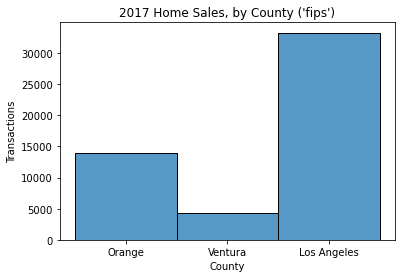

In [10]:
sns.histplot(x='fips_name',data=df)
plt.title("2017 Home Sales, by County ('fips')")
plt.xlabel('County')
plt.ylabel('Transactions')
plt.show()

## Initial Hypotheses
1. Having a fireplace(s), garage(s) and/or pool increases home value.
2. Larger lot size increases home value.
3. Larger square footage increases home value.
4. More bedrooms and bathrooms increase home value.
5. There is a difference in home values due to geography.

# $\blacksquare$ Exploratory Data Analysis

### First, we must split the data.  I want to ensure an important categorical variable, fips name, is equally distributed across the splits, so I will stratify on fips_name.

In [11]:
train, validate, test = splitter(df, target='fips_name')
train.head(2)

Train = 28817 rows (56.0%) | Validate = 12351 rows (24.0%) | Test = 10293 rows (20.0%)


,bedrooms,bathrooms,sqft,selling_price,yearbuilt,fireplaces,lotsize,pools,garages,fips_name
44850,3,2,1534,444179,1986,0,5000,0,2,Orange
37190,3,3,2171,872703,1937,0,10822,0,0,Los Angeles


### I plotted all numerical features against one another to determine any colinear relationships.

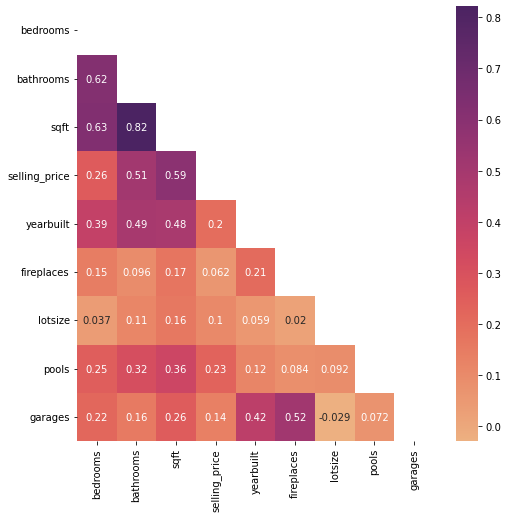

In [12]:
num_cols = [col for col in train.columns if train[col].dtype != 'object']
    
# Create a correlation matrix from the continuous numerical columns
df_num_cols = train[num_cols]
corr = df_num_cols.corr()

# Pass correlation matrix on to sns heatmap
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, cmap="flare", mask=np.triu(corr))
plt.show()

>### *Key Takeaway - sqft and number of bathrooms are highly correlated, and sqft is more closely correlated to selling price than bathrooms, so I feel we can remove bathrooms without losing the information by that feature (since it is wrapped up in sqft)*

>### *Also, LA had no fireplaces or garages in it's dataset, so those two features will be removed before further modeling.*

### Next, I sought to answer questions around my initial hypothesis, and plotted all features against the target, performing statistical testing as well:

In [13]:
import scipy.stats as stats
alpha = .05

### *1. Do homes with pools have a higher selling price than homes without?*

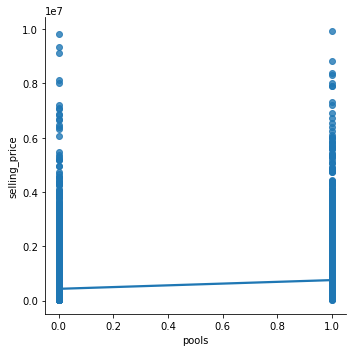

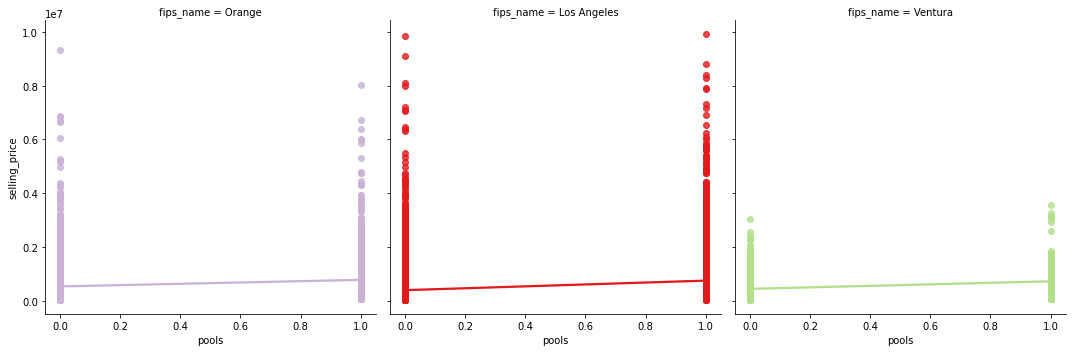

In [14]:
sns.lmplot(data = train, x='pools', y='selling_price')
sns.lmplot(data = train, x='pools', y='selling_price', col = 'fips_name', hue='fips_name', palette='Paired_r')
plt.show()

##### Hypothesis Testing (one-sided, independent t-test):

$H_{0}$ = Homes with pools have the same or lower selling_prices than homes without.

$H_{1}$ = Homes with pools have a higher selling_price than homes without.

Assumptions: (X)Independent | (X) Normal (or 30+ obs) | (?) Equal variances?

In [15]:
print(train[train['pools']==1].selling_price.var())
print(train[train['pools']==0].selling_price.var())

625800342706.9453
211907368860.61053


*Must set equal_var to False*

In [16]:
t, p = stats.ttest_ind(train[train['pools']==1].selling_price, train[train['pools']==0].selling_price, equal_var=False)
print('t: ',t,'p: ', p / 2)
print("Is t < 0? ", t < 0)
print("is p/2 < alpha? ", p / 2 < alpha)

t:  30.214300758241915 p:  3.968740832643604e-189
Is t < 0?  False
is p/2 < alpha?  True


We REJECT the null hypothesis that homes with pools have the same or lower selling_prices than homes without. 

>### *Key Takeaway: Homes with pools have a higher selling price.*

### *2. Does selling price increase with lot size?*

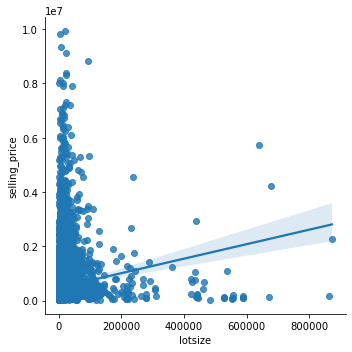

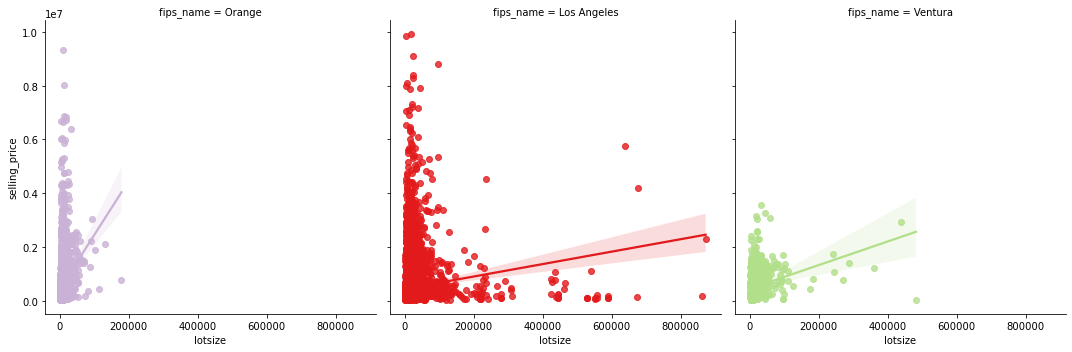

In [17]:
sns.lmplot(data = train, x='lotsize', y='selling_price')
sns.lmplot(data = train, x='lotsize', y='selling_price', col = 'fips_name', hue='fips_name', palette='Paired_r')
plt.show()

##### Hypothesis Testing (Pearson's r correlation):

$H_{0}$ = Lot size is not correlated with selling_price.

$H_{1}$ = Lot size is correlated with selling_price.

In [18]:
corr, p = stats.pearsonr(train.lotsize, train.selling_price)
print('corr: ',corr,'p: ',p)
print("is p/2 < alpha? ", p / 2 < alpha)

corr:  0.10435347788683007 p:  1.3834226433621537e-70
is p/2 < alpha?  True


We REJECT the null hypothesis that lot size is not correlated with selling price.

>### *Key Takeaway: Selling price increases with lot size.*

### *3. Does selling price increase with a home's square footage?*

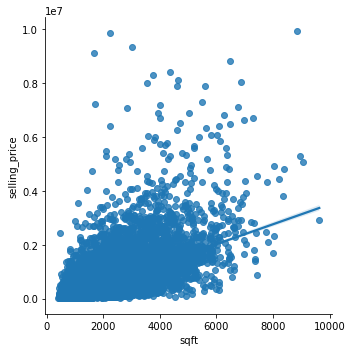

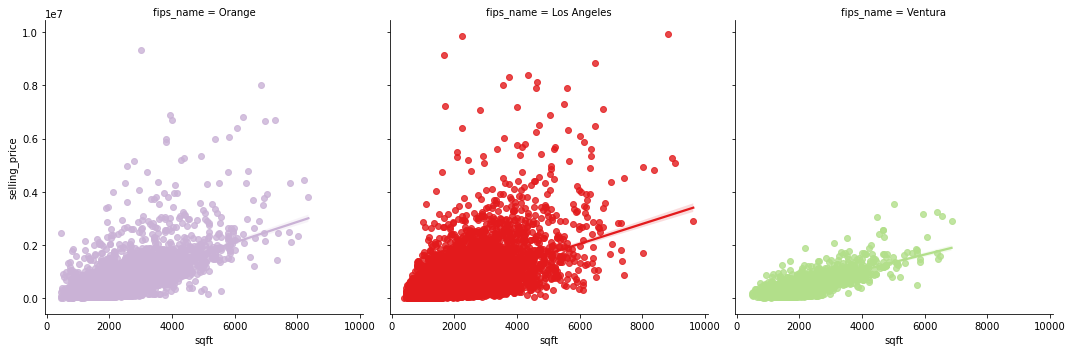

In [19]:
sns.lmplot(data = train, x='sqft', y='selling_price')
sns.lmplot(data = train, x='sqft', y='selling_price', col = 'fips_name', hue='fips_name', palette='Paired_r')
plt.show()

##### Hypothesis Testing (Pearson's r correlation):

$H_{0}$ = Square footage of home is not correlated with selling_price.

$H_{1}$ = Square footage of home is correlated with selling_price.

In [20]:
corr, p = stats.pearsonr(train.sqft, train.selling_price)
print('corr: ',corr,'p: ',p)
print("is p/2 < alpha? ", p / 2 < alpha)

corr:  0.5910518561073774 p:  0.0
is p/2 < alpha?  True


We REJECT the null hypothesis that square footage of home is not correlated with selling price.

>### *Key Takeaway: Selling price increases with home square footage.*

### *4. Does selling price increase with number of bedrooms?*
(Removed number of bathrooms from question)

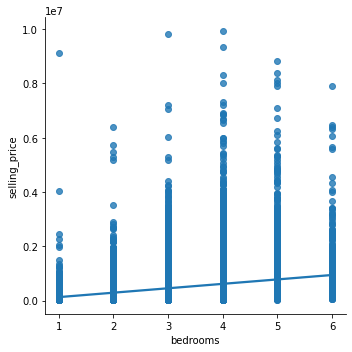

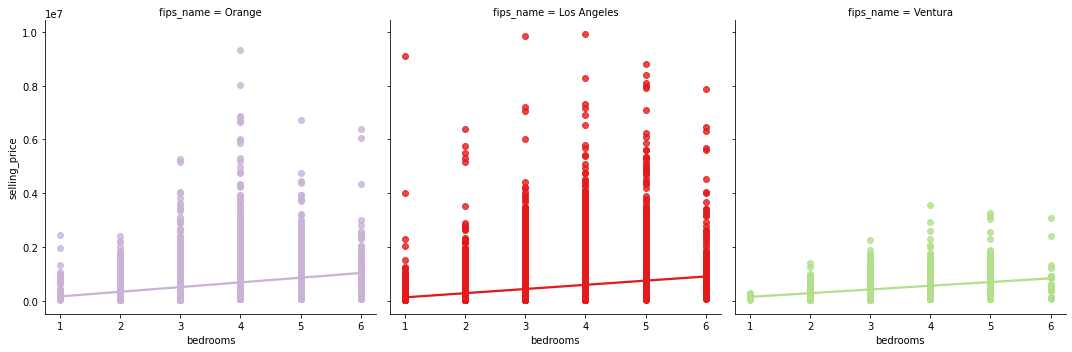

In [21]:
sns.lmplot(data = train, x='bedrooms', y='selling_price')
sns.lmplot(data = train, x='bedrooms', y='selling_price', col = 'fips_name', hue='fips_name', palette='Paired_r')
plt.show()

##### Hypothesis Testing (Pearson's r correlation):

$H_{0}$ = Bedrooms are not correlated with selling_price.

$H_{1}$ = Bedrooms are correlated with selling_price.

In [22]:
corr, p = stats.pearsonr(train.bedrooms, train.selling_price)
print('corr: ',corr,'p: ',p)
print("is p/2 < alpha? ", p / 2 < alpha)

corr:  0.2618880816656596 p:  0.0
is p/2 < alpha?  True


We REJECT the null hypothesis that bedrooms are not correlated with selling price.

>### *Key Takeaway: Selling price increases with number of bedrooms.*

### *5. Does Orange county have the highest mean selling price, followed by Ventura and then LA?*

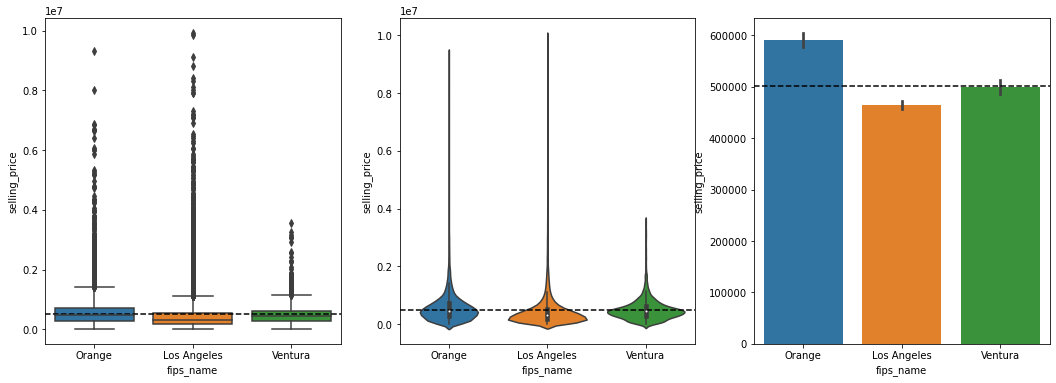

In [39]:
plt.figure(figsize = (18,6))
plt.subplot(1,3,1)
sns.boxplot(data = train, x='fips_name', y='selling_price')
plt.axhline(train['selling_price'].mean(), ls='--', color='black')
plt.subplot(1,3,2)
sns.violinplot(data = train, x='fips_name', y='selling_price')
plt.axhline(train['selling_price'].mean(), ls='--', color='black')
plt.subplot(1,3,3)
sns.barplot(data = train, x='fips_name', y='selling_price')
plt.axhline(train['selling_price'].mean(), ls='--', color='black')
plt.show()

##### Hypothesis Testing (multiple one-sided, independent t-tests):

$H_{0}$ = [Orange, Ventura] county has the same or lower mean selling prices as [Ventura, Los Angeles] county.

$H_{1}$ = [Orange, Ventura] county has a higher mean selling price than [Ventura, Los Angeles] county.

Assumptions: (X)Independent | (X) Normal (or 30+ obs) | (?) Equal variances?

In [24]:
print(train[train['fips_name']=='Orange'].selling_price.var())
print(train[train['fips_name']=='Ventura'].selling_price.var())
print(train[train['fips_name']=='Los Angeles'].selling_price.var())

323491062297.0251
123703491206.47647
332206493893.728


*While Orange and LA have equal variances, I'll go ahead and set to False when comparing to Ventura*

1. Orange vs Ventura

In [25]:
t, p = stats.ttest_ind(train[train['fips_name']=='Orange'].selling_price, train[train['fips_name']=='Ventura'].selling_price, equal_var=False)
t, p / 2
print('t: ',t,'p/2: ',p/2)
print("Is t < 0? ", t < 0)
print("is p/2 < alpha? ", p / 2 < alpha)

t:  9.394935151777425 p/2:  3.878429917263677e-21
Is t < 0?  False
is p/2 < alpha?  True


We REJECT the null hypothesis that Orange has the same or lower selling_prices than Ventura.

In [26]:
t, p = stats.ttest_ind(train[train['fips_name']=='Ventura'].selling_price, train[train['fips_name']=='Los Angeles'].selling_price, equal_var=False)
t, p / 2
print('t: ',t,'p/2: ',p/2)
print("Is t < 0? ", t < 0)
print("is p/2 < alpha? ", p / 2 < alpha)

t:  4.281993153716442 p/2:  9.464931713388607e-06
Is t < 0?  False
is p/2 < alpha?  True


We REJECT the null hypothesis that Ventura has the same or lower selling_prices than Los Angeles.

>### *Key Takeaway: Orange county has the highest selling prices, followed by Ventura and then Los Angeles counties.*

## EDA Outcomes:

1. Orange county is associated with the highest selling price, then Ventura then LA.
2. Bathrooms highly correlated with square footage, and square footage is better correlated with selling prices (increase together), so dropping bathrooms.
3. Pools, bedrooms and lot size are correlated with higher selling prices (albeit not as strongly as square footage), so keeping them for model.
4. Dropping garages and fireplaces.
4. Quality metric seems wrong (higher seems better), was only for LA, and didn't improve an LA-only parallel model, but seems very interesting to explore in the future.

In [27]:
# Remove columns from split dataset
columns_to_remove = ['bathrooms','fireplaces','garages']
train = train.drop(columns = columns_to_remove)
validate = validate.drop(columns = columns_to_remove)
test = test.drop(columns = columns_to_remove)

# $\blacksquare$ Feature Engineering

##### Scale (used Min-Max) and encode the dataset:

In [28]:
train_scaled, validate_scaled, test_scaled = scale_zillow(train, validate, test)
train_scaled.head(2)

,bedrooms,sqft,yearbuilt,lotsize,pools,fips_name,selling_price,fips_name_Los Angeles,fips_name_Orange,fips_name_Ventura
44850,0.4,0.122440,0.782609,0.005000,0.0,Orange,444179,0,1,0
37190,0.4,0.191462,0.427536,0.011677,0.0,Los Angeles,872703,1,0,0


#### Seperate target and features:

In [29]:
X_train = train_scaled.drop(columns=['fips_name','selling_price'])
y_train = train_scaled.selling_price

X_validate = validate_scaled.drop(columns=['fips_name','selling_price'])
y_validate = validate_scaled.selling_price

X_test = test_scaled.drop(columns=['fips_name','selling_price'])
y_test = test_scaled.selling_price

##### I performed both a SelecKBest and RFE.  RFE ran without issue and is considered superior, so went with it:

In [30]:
feature_list = []
for i in range(1,9):
# initialize the ML algorithm
    lm = LinearRegression()

    # create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
    rfe = RFE(lm, n_features_to_select=i)

    # fit the data using RFE
    rfe.fit(X_train,y_train)  

    # get the mask of the columns selected
    feature_mask = rfe.support_

    # get list of the column names. 
    rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()
    results = {'Number of Features' : i,'Features':rfe_feature}
    feature_list.append(results)
feature_list = pd.DataFrame(feature_list).round(2).set_index('Features')
feature_list

,Number of Features
Features,
[sqft],1
"[sqft, fips_name_Ventura]",2
"[sqft, fips_name_Orange, fips_name_Ventura]",3
"[sqft, fips_name_Los Angeles, fips_name_Orange, fips_name_Ventura]",4
"[bedrooms, sqft, fips_name_Los Angeles, fips_name_Orange, fips_name_Ventura]",5
"[bedrooms, sqft, yearbuilt, fips_name_Los Angeles, fips_name_Orange, fips_name_Ventura]",6
"[bedrooms, sqft, yearbuilt, lotsize, fips_name_Los Angeles, fips_name_Orange, fips_name_Ventura]",7
"[bedrooms, sqft, yearbuilt, lotsize, pools, fips_name_Los Angeles, fips_name_Orange, fips_name_Ventura]",8


##### Then used an RFE Cross Validation funtion to determine optimal number of features, and it looks like we should model using all of the features.

In [31]:
rfecv = RFECV(lm, min_features_to_select = 1)
rfecv.fit(X_train, y_train)
feature_mask = rfecv.support_
rfecv_feature = X_train.iloc[:,feature_mask].columns.tolist()
print(rfecv_feature)

['bedrooms', 'sqft', 'yearbuilt', 'lotsize', 'pools', 'fips_name_Los Angeles', 'fips_name_Orange', 'fips_name_Ventura']


# $\blacksquare$ Modeling

#### KEY METRIC: RMSE

Used Root Mean Square Error, as it gives us performance of the models in the actual unit's selling price is in, USD.

#### BASELINE:

In [32]:
model_comparator_list = []
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict target_pred_mean
selling_price_pred_mean = y_train['selling_price'].mean()
y_train['selling_price_pred_mean'] = selling_price_pred_mean
y_validate['selling_price_pred_mean'] = selling_price_pred_mean

# 2. compute target_pred_median
selling_price_pred_median = y_train['selling_price'].median()
y_train['selling_price_pred_median'] = selling_price_pred_median
y_validate['selling_price_pred_median'] = selling_price_pred_median

# 3. RMSE of target_pred_mean
rmse_train_mean = mean_squared_error(y_train.selling_price, y_train.selling_price_pred_mean)**(1/2)
rmse_validate_mean = mean_squared_error(y_validate.selling_price, y_validate.selling_price_pred_mean)**(1/2)

# 4. RMSE of target_pred_median
rmse_train_median = mean_squared_error(y_train.selling_price, y_train.selling_price_pred_median)**(1/2)
rmse_validate_median = mean_squared_error(y_validate.selling_price, y_validate.selling_price_pred_median)**(1/2)

results = {'Model' : 'Baseline Median','RMSE Train':rmse_train_median,'RMSE Validate':rmse_validate_median}
model_comparator_list.append(results)
results = {'Model' : 'Baseline Mean','RMSE Train':rmse_train_mean,'RMSE Validate':rmse_validate_mean}
model_comparator_list.append(results)

pd.DataFrame(model_comparator_list).round(2).set_index('Model')

,RMSE Train,RMSE Validate
Model,,
Baseline Median,577124.18,595999.56
Baseline Mean,561729.01,579692.60


#### MODEL OUTCOME COMPARISON

In [33]:
# Uses externally created function to generate dataframe
model_comparator.zillow_model_comparator(X_train,y_train,X_validate,y_validate)

Model,Baseline Median,Baseline Mean,OLS,LassoLars,GLM,"Polynomial, Deg. 2","Polynomial, Deg. 3"
RMSE Train,577124.18,561729.01,443065.85,443067.19,472870.23,432589.98,425962.84
RMSE Validate,595999.56,579692.60,465534.57,465540.27,488653.76,458005.34,460517.30
Overfit %,3.27,3.20,5.07,5.07,3.34,5.88,8.11


>### *2nd degree Polynomial Regression Produces the Best Model*

## Test:

In [34]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_test_scaled
X_test_degree2 = pf.transform(X_test)

y_test = pd.DataFrame(y_test)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.selling_price)

# predict on test
y_test['selling_price_pred_lm'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.selling_price, y_test.selling_price_pred_lm)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  432903.37252654514


## We got the model down to $433,000, which is a substantial improvement over baseline (23% better), but still not that great.  I therefore decided to see if we could do a bit better by taking county - that fips code - out of the model and adding it as a pre-filtering step instead.

In [35]:
# Uses externally created function to generate dataframes by location
model_comparator.count_filtered(df)

Train = 7789 rows (56.0%) | Validate = 3339 rows (24.0%) | Test = 2782 rows (20.0%)
You did not stratify.  If looking to stratify, ensure to add argument: "target = variable to stratify on".
Orange County Results
                    RMSE Train  RMSE Validate  Overfit %
Model                                                   
Baseline Median      570073.70      596801.10       4.69
Baseline Mean        557990.98      581731.01       4.25
OLS                  415021.66      439618.18       5.93
LassoLars            415022.05      439617.81       5.93
GLM                  404426.58      439462.08       8.66
Polynomial, Deg. 2   391402.74      497610.02      27.14
Polynomial, Deg. 3   377962.87     3225166.88     753.30

-----

Train = 2395 rows (56.0%) | Validate = 1027 rows (24.0%) | Test = 856 rows (20.0%)
You did not stratify.  If looking to stratify, ensure to add argument: "target = variable to stratify on".
Ventura County Results
                    RMSE Train  RMSE Validate  Overfi

# $\blacksquare$ Conclusions

## What increases a home's selling price?
- Location has the biggest impact on selling price. 
- Across all geographies, square footage is the best predictor of selling price.
- Lot size, having a pool, and number of bedrooms also impacts selling price. 

## Model Effectiveness
- From a modeling standpoint, a 2nd degree polynomial is the best when looking at all the data.
- However, for more granularity and better model outcomes, each county has different optimal models (LassoLars, GLM)

## Recommendations and Next Steps
- In addition to modeling by county or other geographic metric, models could be vastly improved if price tranched as well (i.e homes < 500k, 500k-1MM, etc.).  This of course relies on having enough training data present.
- The quality metric offered improvements over the current model, but is small and we only had these scores for LA.  This could be a really powerful predictor if done right.  Maybe have some kind of standardized model based on ML techniques using such things a photographs of the home.